In [1]:
!pip install -q ruamel.yaml
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/' + str(input("Project path relative to '/content/drive/MyDrive/': (default: 'Colab Projects/QuantumFlow') ") or "Colab Projects/QuantumFlow")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project path relative to '/content/drive/MyDrive/': (default: 'Colab Projects/QuantumFlow') 


In [2]:
import os
import sys

os.chdir(project_path)
sys.path.append(project_path)

if not os.path.exists('experiments'): os.makedirs('experiments')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import quantumflow
import quantumflow.noninteracting_1d

# Algortihm Analysis

In [35]:
experiment = 'snyder_2012'
run_name = 'train_dataset'

preview = 5
analysis_dataset_size = 100
figsize = (20, 3)
dpi = None

base_dir = os.path.join(project_path, "experiments", experiment)
params = quantumflow.utils.load_yaml(os.path.join(base_dir, 'hyperparams.yaml'))[run_name]
run_dir = os.path.join(base_dir, run_name)

params['dataset_size'] = analysis_dataset_size

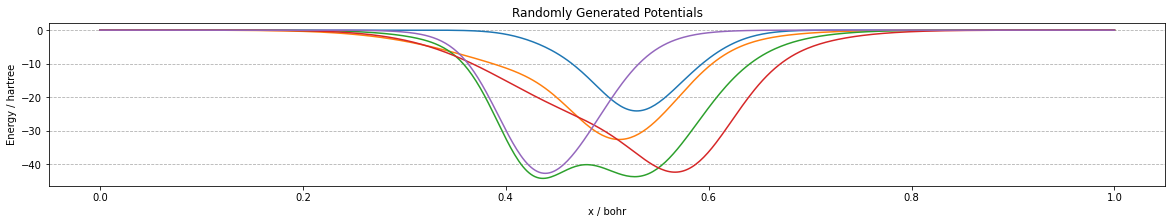

In [36]:
dtype = params['dtype']
N = params['N']
numerov_init_slope = params['numerov_init_slope']

tf.keras.backend.clear_session()
tf.keras.backend.set_floatx(dtype)
tf.random.set_seed(params['seed'])

potential, x, h = quantumflow.noninteracting_1d.generate_potentials(return_x=True, return_h=True, **params)

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(potential)[:, :preview]) # only plot first potentials
plt.title("Randomly Generated Potentials")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

In [37]:
import importlib
importlib.reload(quantumflow.noninteracting_1d)

<module 'quantumflow.noninteracting_1d' from '/content/drive/MyDrive/Colab Projects/QuantumFlow/quantumflow/noninteracting_1d/__init__.py'>

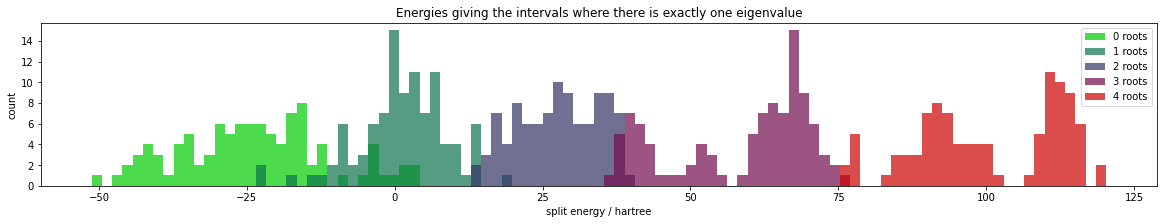

In [38]:
split_energies = quantumflow.noninteracting_1d.find_split_energies(potential, N, h, dtype, numerov_init_slope).numpy()

plt.figure(figsize=figsize, dpi=dpi)
bins = np.linspace(min(split_energies.flatten()), max(split_energies.flatten()), 100)

for i in range(split_energies.shape[1]):
    color = i/(split_energies.shape[1] - 1)
    plt.hist(split_energies[:, i], bins, alpha=0.7, color=[0.8*color**2, 0.8*(1-color)**2, 1.6*color*(1-color)], label= str(i) + " roots")

plt.xlabel('split energy / hartree')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title("Energies giving the intervals where there is exactly one eigenvalue")
plt.show()

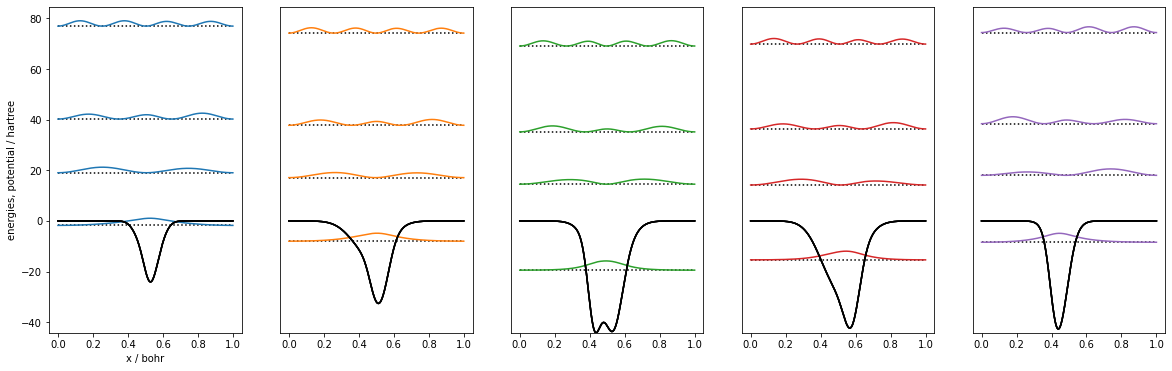

In [39]:
energies, wavefunctions = quantumflow.noninteracting_1d.solve_schroedinger(potential, N, h, dtype, numerov_init_slope)

fig, axs = plt.subplots(1, preview, figsize=(figsize[0], figsize[1]*2), dpi=dpi)

for i, plot in enumerate(wavefunctions.numpy()[:preview]**2 + energies.numpy()[:preview, np.newaxis, :]):
    for n, plot_single in enumerate(plot.transpose()):
        axs[i].plot(x, potential[i], 'k')
        axs[i].plot(x, np.ones(x.shape)*energies[i, n], ':k')
        axs[i].plot(x, plot_single, 'C' + str(i%10))
        axs[i].set_ylim([np.min(potential.numpy()[:preview]), max(np.max(energies.numpy()[:preview]*1.1), 0.5)])
        if i == 0: 
            axs[i].set_ylabel('energies, potential / hartree')
            axs[i].set_xlabel("x / bohr")
        else:
            axs[i].get_yaxis().set_visible(False)
#fig.suptitle('Numerov Solution Energies and Densities')
plt.show()

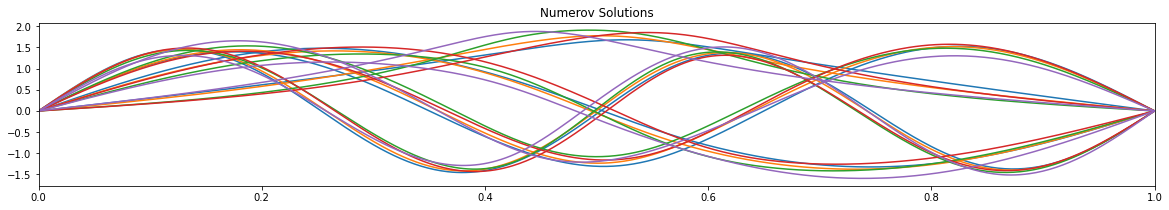

In [40]:
plt.figure(figsize=figsize, dpi=dpi)
for i, plot in enumerate(wavefunctions[:preview]):
    plt.plot(x, plot, 'C' + str(i%10))
plt.xlim(x.numpy()[[0, -1]])
plt.title('Numerov Solutions')
plt.show()

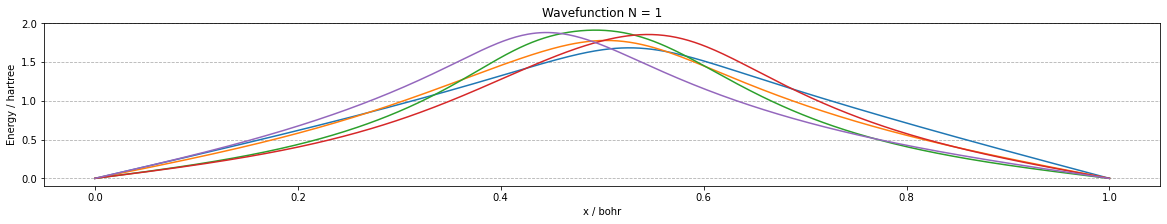

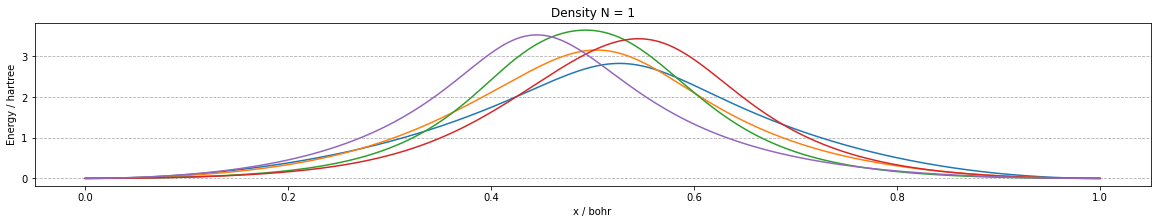

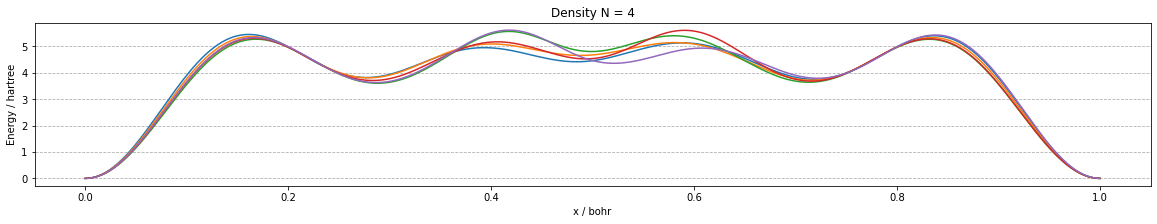

In [41]:
densities = wavefunctions**2
total_density = tf.reduce_sum(densities, axis=2)

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(wavefunctions[:, :, 0])[:, :preview])
plt.title("Wavefunction N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(densities[:, :, 0])[:, :preview])
plt.title("Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(total_density)[:, :preview])
plt.title(f"Density N = {N}")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

In [42]:
laplace_wavefunctions = quantumflow.utils.laplace_five_point(wavefunctions, h)
kinetic_energy_densities = -0.5*wavefunctions*laplace_wavefunctions

kinetic_energies = quantumflow.utils.integrate(kinetic_energy_densities, h)

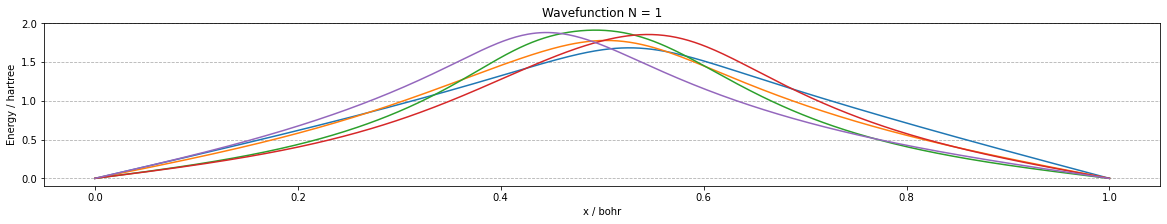

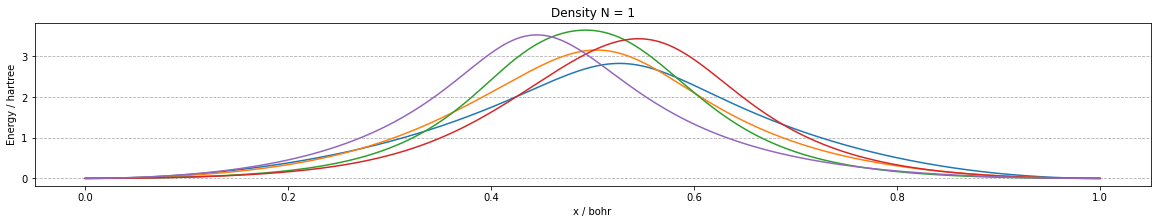

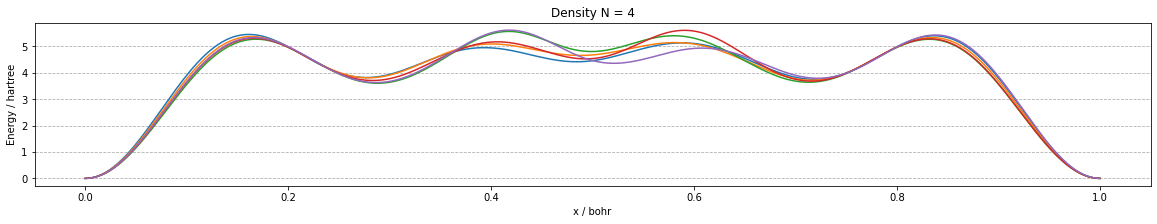

In [43]:
densities = wavefunctions**2
total_density = tf.reduce_sum(densities, axis=2)

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(wavefunctions[:, :, 0])[:, :preview])
plt.title("Wavefunction N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(densities[:, :, 0])[:, :preview])
plt.title("Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(total_density)[:, :preview])
plt.title(f"Density N = {N}")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

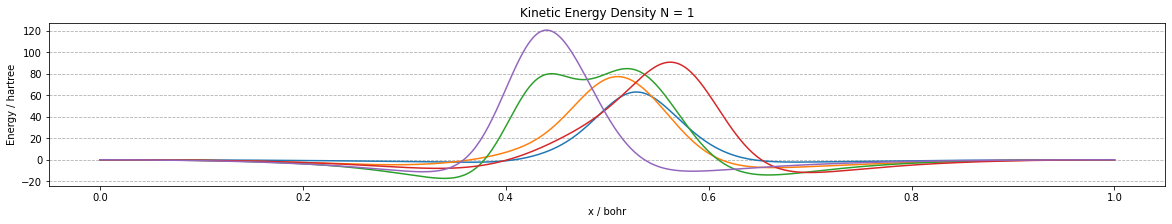

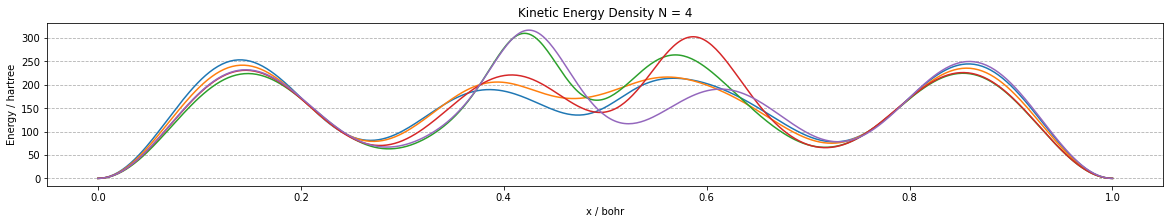

In [44]:
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(kinetic_energy_densities[:, :, 0])[:, :preview])
plt.title("Kinetic Energy Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(tf.reduce_sum(kinetic_energy_densities, axis=2))[:, :preview])
plt.title(f"Kinetic Energy Density N = {N}")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

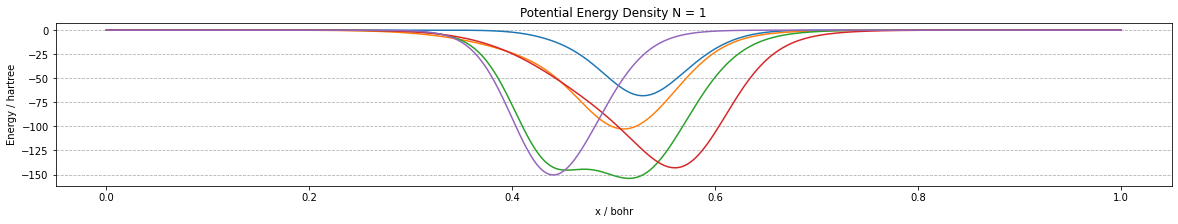

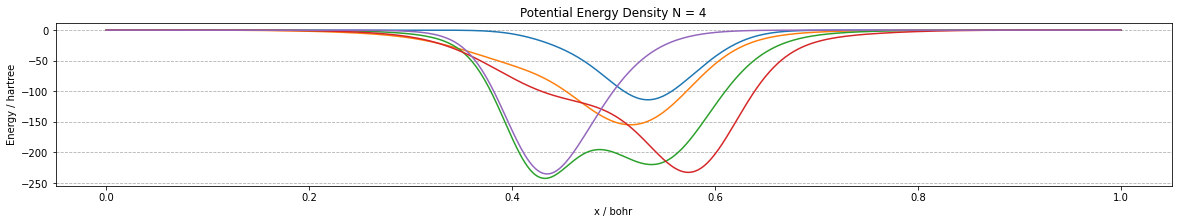

In [45]:
potential_energy_densities = tf.expand_dims(potential, axis=2)*wavefunctions**2
potential_energies = quantumflow.utils.integrate(potential_energy_densities, h)

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(potential_energy_densities[:, :, 0])[:, :preview])
plt.title("Potential Energy Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(tf.reduce_sum(potential_energy_densities, axis=2))[:, :preview])
plt.title(f"Potential Energy Density N = {N}")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()


N=1 energy:                  [ -1.76879976  -8.00938864 -19.45743795 -15.38697266  -8.42673701]
N=1 potential energy:        [ -7.67136458 -14.88925894 -28.79881816 -23.53621418 -16.48586245]
N=1 kinetic energy:          [5.9025648  6.87987029 9.34138019 8.14924151 8.05912541]
N=1 kinetic energy indirect: [5.90256481 6.8798703  9.34138021 8.14924152 8.05912544]


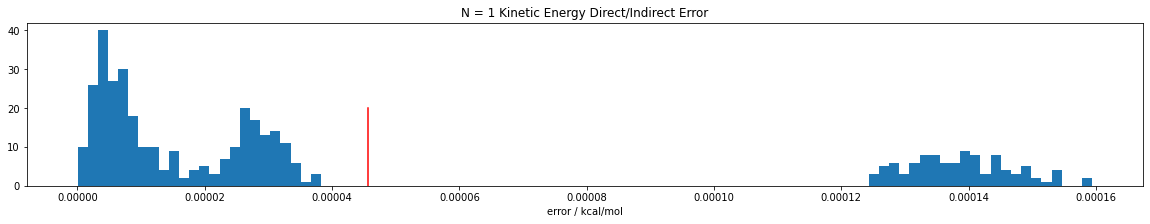

In [46]:
kcalmol_per_hartree = 627.51
kinetic_energies_indirect = energies - potential_energies

print('N=1 energy:                 ', energies[:preview, 0].numpy())
print('N=1 potential energy:       ', potential_energies[:preview, 0].numpy())
print('N=1 kinetic energy:         ', kinetic_energies[:preview, 0].numpy())
print('N=1 kinetic energy indirect:', kinetic_energies_indirect[:preview, 0].numpy())

err = np.abs(kinetic_energies - kinetic_energies_indirect).flatten()*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err, bins=100)
plt.plot([np.mean(err), np.mean(err)], [0, np.sqrt(params['dataset_size']*N)], 'r')
plt.title("N = 1 Kinetic Energy Direct/Indirect Error")
plt.xlabel('error / kcal/mol')
plt.show()

total energy:                  [134.48166584 121.08347858  99.34030671 105.02465091 122.41963846]
total potential energy:        [-14.09652429 -28.08164656 -51.63005178 -44.89279584 -27.1260442 ]
total kinetic energy direct:   [148.57818988 149.16512487 150.97035817 149.91744645 149.54568236]
total kinetic energy indirect: [148.57819013 149.16512514 150.97035849 149.91744675 149.54568266]


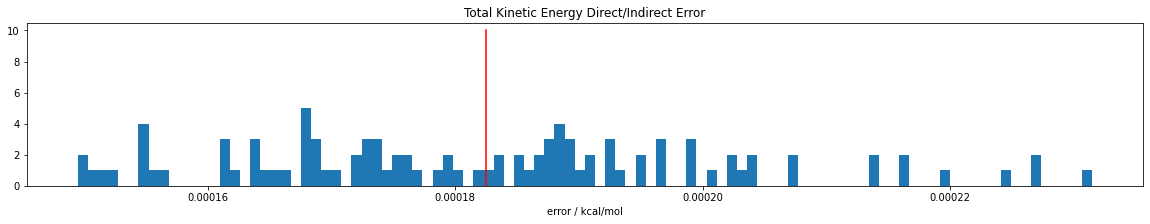

In [47]:
total_energy = tf.reduce_sum(energies, axis=-1)
print('total energy:                 ', total_energy[:preview].numpy())

potential_energy = tf.reduce_sum(potential_energies, axis=-1)
print('total potential energy:       ', potential_energy[:preview].numpy())

kinetic_energy = tf.reduce_sum(kinetic_energies, axis=-1)
print('total kinetic energy direct:  ', kinetic_energy[:preview].numpy())

kinetic_energy_indirect = tf.reduce_sum(kinetic_energies_indirect, axis=-1)
print('total kinetic energy indirect:', kinetic_energy_indirect[:preview].numpy())

err = np.abs(kinetic_energy - kinetic_energy_indirect).flatten()*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err, bins=100)
plt.plot([np.mean(err), np.mean(err)], [0, np.sqrt(params['dataset_size'])], 'r')
plt.title("Total Kinetic Energy Direct/Indirect Error")
plt.xlabel('error / kcal/mol')
plt.show()

## Direct 5-point stencil method

total kinetic energy 5     : [148.5781904  149.16512534 150.97035856 149.91744686 149.54568283]


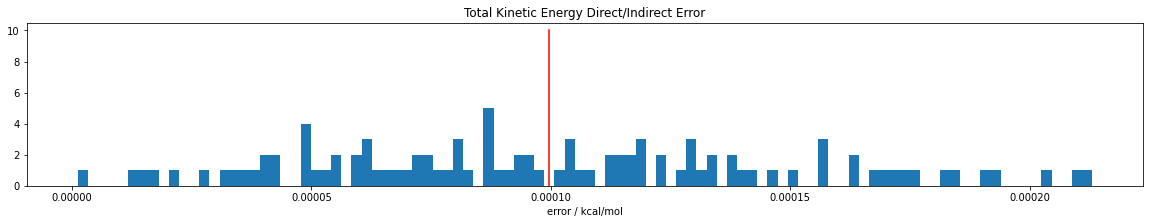

In [48]:
def laplace_5(wavefunctions, h):
    lpwf = 1/(12*h**2)*(-wavefunctions[:, 4:] + 16*wavefunctions[:, 3:-1] - 30*wavefunctions[:, 2:-2] + 16*wavefunctions[:, 1:-3] - wavefunctions[:, 0:-4])
    return tf.concat([3*lpwf[:, 0:1] - 2*lpwf[:, 1:2], 2*lpwf[:, 0:1] - lpwf[:, 1:2], lpwf, 2*lpwf[:, -1:] - lpwf[:, -2:-1], 3*lpwf[:, -1:] - 2*lpwf[:, -2:-1]], axis=1)

laplace_wavefunctions_5 = laplace_5(wavefunctions, h)
kinetic_energy_densities_5 = -0.5*wavefunctions*laplace_wavefunctions_5

kinetic_energies_5 = quantumflow.utils.integrate(kinetic_energy_densities_5, h)

kinetic_energy_5 = tf.reduce_sum(kinetic_energies_5, axis=-1)
print('total kinetic energy 5     :', kinetic_energy_5[:preview].numpy())

err = np.abs(kinetic_energy_indirect - kinetic_energy_5).flatten()*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err, bins=100)
plt.plot([np.mean(err), np.mean(err)], [0, np.sqrt(params['dataset_size'])], 'r')
plt.title("Total Kinetic Energy Direct/Indirect Error")
plt.xlabel('error / kcal/mol')
plt.show()


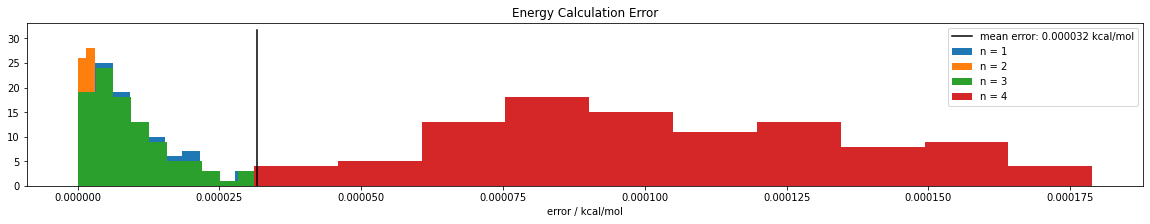

In [49]:
direct_energies = potential_energies + kinetic_energies_5

kcalmol_per_hartree = 627.51
err = np.abs(energies - direct_energies)*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err[:, 0], bins=10, label='n = 1')
plt.hist(err[:, 1], bins=10, label='n = 2')
plt.hist(err[:, 2], bins=10, label='n = 3')
plt.hist(err[:, 3], bins=10, label='n = 4')
plt.plot([np.mean(err.flatten()), np.mean(err.flatten())], [0, np.sqrt(1000)], 'k' ,label='mean error: {:.06f} kcal/mol'.format(np.mean(err.flatten())))
plt.title("Energy Calculation Error")
plt.xlabel('error / kcal/mol')
plt.legend()
plt.show()

#Alternative Kinetic Energy Density Formula

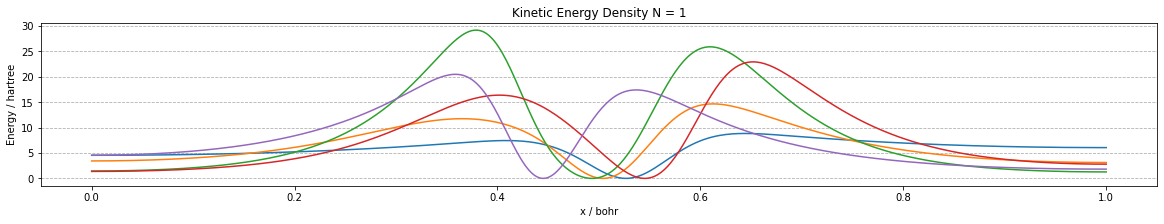

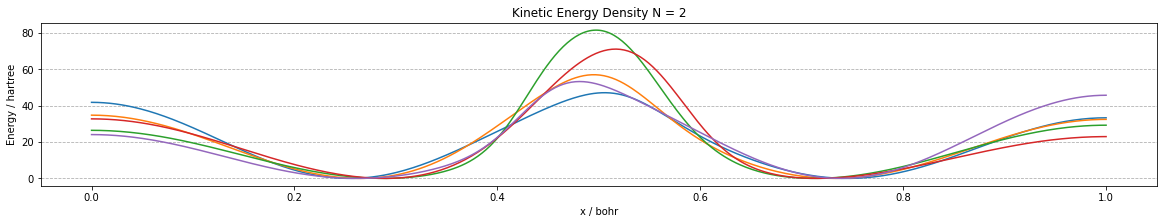

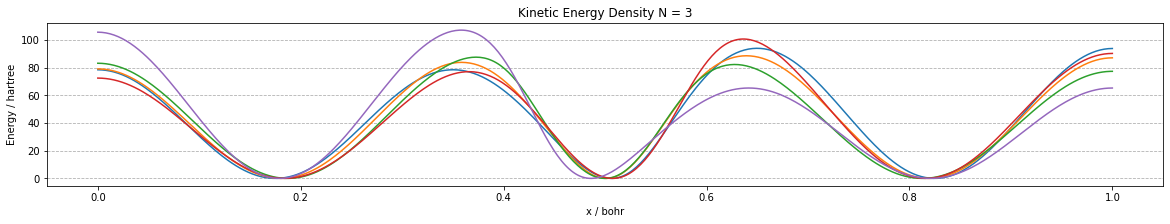

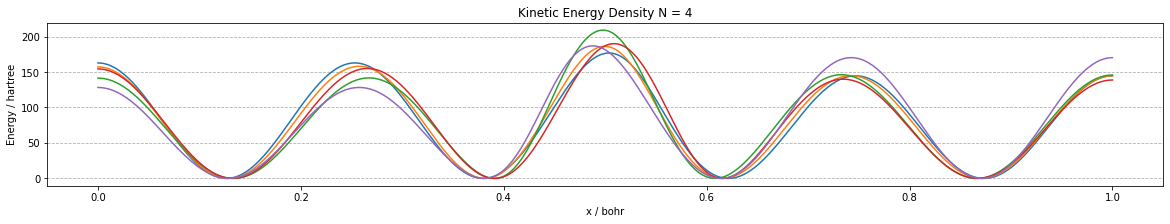

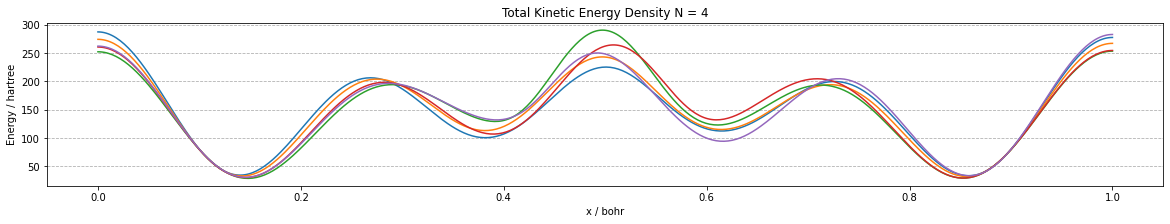

total kinetic energy 2     : [148.5781904  149.16512534 150.97035856 149.91744686 149.54568283]


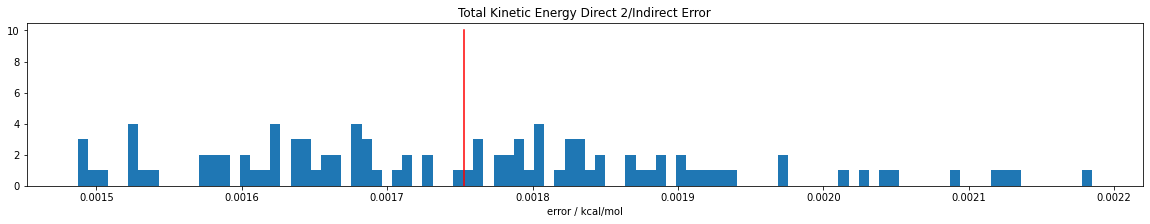

In [33]:
derivative_wavefunctions = quantumflow.utils.derivative_five_point(wavefunctions, h)

kinetic_energy_densities_2 = 0.5*tf.square(derivative_wavefunctions)

kinetic_energies_2 = quantumflow.utils.integrate(kinetic_energy_densities_2, h)

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(kinetic_energy_densities_2[:, :, 0])[:, :preview])
plt.title("Kinetic Energy Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()


plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(kinetic_energy_densities_2[:, :, 1])[:, :preview])
plt.title("Kinetic Energy Density N = 2")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()



plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(kinetic_energy_densities_2[:, :, 2])[:, :preview])
plt.title("Kinetic Energy Density N = 3")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(kinetic_energy_densities_2[:, :, 3])[:, :preview])
plt.title("Kinetic Energy Density N = 4")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()


plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(tf.reduce_sum(kinetic_energy_densities_2, axis=2))[:, :preview])
plt.title(f"Total Kinetic Energy Density N = {N}")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

kinetic_energy_2 = tf.reduce_sum(kinetic_energies_2, axis=-1)
print('total kinetic energy 2     :', kinetic_energy_5[:preview].numpy())

err = np.abs(kinetic_energy_indirect - kinetic_energy_2).flatten()*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err, bins=100)
plt.plot([np.mean(err), np.mean(err)], [0, np.sqrt(params['dataset_size'])], 'r')
plt.title("Total Kinetic Energy Direct 2/Indirect Error")
plt.xlabel('error / kcal/mol')
plt.show()


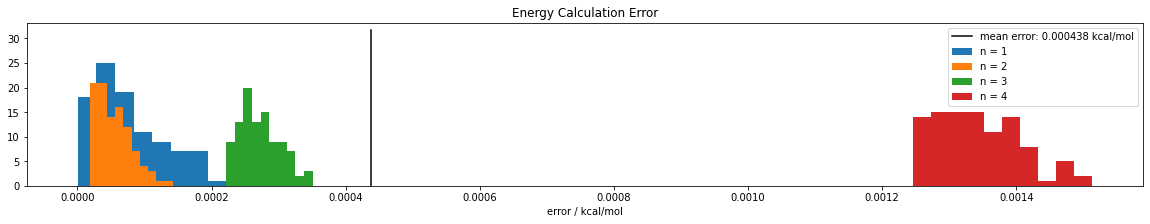

In [34]:
direct_energies = potential_energies + kinetic_energies_2

kcalmol_per_hartree = 627.51
err = np.abs(energies - direct_energies)*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err[:, 0], bins=10, label='n = 1')
plt.hist(err[:, 1], bins=10, label='n = 2')
plt.hist(err[:, 2], bins=10, label='n = 3')
plt.hist(err[:, 3], bins=10, label='n = 4')
plt.plot([np.mean(err.flatten()), np.mean(err.flatten())], [0, np.sqrt(1000)], 'k' ,label='mean error: {:.06f} kcal/mol'.format(np.mean(err.flatten())))
plt.title("Energy Calculation Error")
plt.xlabel('error / kcal/mol')
plt.legend()
plt.show()